# Generative Adversarial Network for Molecular Graph images

This block

- imports all modules/libraries needed
- contains a function for a learning rate scheduler (if needed)
- reads in SMILES strings and creates a list
- featurizes via the SmilesTo Image featurizer from Deepchem (https://github.com/deepchem/deepchem)
- Four channel image used for featurization
  * Atomic numbers + bonds
  * partial charges
  * valence
  * hybridization

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import deepchem as dc
import time
from rdkit import Chem
from functools import partial
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, Draw
from sklearn.model_selection import train_test_split

def exp_decay(lr0,s):
    def exp_decay_fcn(epoch):
        return lr0*0.1**(epoch/s)
    return exp_decay_fcn

#df = pd.read_csv("392-azo.csv")
#df = pd.read_csv("212-azo.csv")
#df = pd.read_csv("604-azo.csv")
#df = pd.read_csv("621-azo.csv")
df = pd.read_csv("6731-azo.csv")

Xa = [""]*len(df)
w = [""]*len(df)
i=0
for name in df["SMILES"]:
    Xa[i]=name
    w[i]=1.0
    i += 1
Xa = list(Xa)
w=list(w)

#===========================================================================================
#featurizer

featurizer=dc.feat.SmilesToImage(img_spec="engd")
featname="SmilesToImage"

f = featurizer.featurize(Xa)
print("Number of features and datapoints: ",f.shape)

#===========================================================================================
print("featurization done with: ",featname)

# set npp for how many points in the dataset, len(df) for whole dataset
nnp=len(df)

#set y to lambdamax
y = df["Lmax"]

#set dataset and split

dataset = dc.data.NumpyDataset(X=f[:nnp,:,:,:], y=y[:nnp], ids=Xa[:nnp], w=w[:nnp])


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (C:\ProgramData\Anaconda3\envs\rdkitenv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Number of features and datapoints:  (6731, 80, 80, 4)
featurization done with:  SmilesToImage


## Define the Discriminator and Generator

- architecture adapted from https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition

In [21]:
embsize=128
dropout_rate = 0.45

#=======================================================================================================

discriminator_input = tf.keras.layers.Input(shape=[80,80,4])
x = tf.keras.layers.Conv2D(filters=64,kernel_size=(4,4), strides=2,padding="same", use_bias = False)(discriminator_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Conv2D(filters=128,kernel_size=(4,4), strides=2,padding="same", use_bias = False)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Conv2D(filters=256,kernel_size=(4,4), strides=2,padding="same", use_bias = False)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Conv2D(filters=512,kernel_size=(4,4), strides=2,padding="same", use_bias = False)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Conv2D(filters=1,kernel_size=(5,5), strides=1,padding="valid", use_bias = False,
                          activation="sigmoid")(x)
discriminator_output = tf.keras.layers.Flatten()(x)

discriminator = tf.keras.models.Model(discriminator_input,discriminator_output)
#=======================================================================================================

generator_input = tf.keras.layers.Input(shape=(embsize,))
x = tf.keras.layers.Reshape((1,1,embsize))(generator_input)
x = tf.keras.layers.Conv2DTranspose(filters=512,kernel_size=(5,5),strides=1, padding="valid", use_bias = False)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Conv2DTranspose(filters=256,kernel_size=(4,4),strides=2, padding="same", use_bias = False)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Conv2DTranspose(filters=128,kernel_size=(4,4),strides=2, padding="same", use_bias = False)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(4,4),strides=2, padding="same", use_bias = False)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
generator_output = tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(4,4),strides=2, padding="same", 
                                                   activation = "sigmoid", use_bias = False)(x)  #using activation = "sigmoid" here leads to blue backgrounds

generator = tf.keras.models.Model(generator_input,generator_output)

print("Generator and Discriminator built.")

Generator and Discriminator built.


## Training for the GAN

- training loop adapted from https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition

In [22]:
class GAN(tf.keras.models.Model):
    def __init__(self,discriminator,generator,latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(GAN,self).compile()
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [ self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size,self.latent_dim))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(random_latent_vectors, training = True)
            real_predictions = self.discriminator(real_images, training = True)
            fake_predictions = self.discriminator(generated_images, training = True)

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + 0.1*tf.random.uniform(tf.shape(real_predictions))
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels + 0.1*tf.random.uniform(tf.shape(fake_predictions))

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0
            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_variables)

        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

dcgan = GAN(discriminator = discriminator, generator = generator, latent_dim = embsize)

dcgan.compile(d_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0001),
             g_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.5, beta_2 = 0.999))
dcgan.fit(dataset.X, epochs = 2)

Epoch 1/2
211/211 [==============================] - 106s 483ms/step - d_loss: 1.9860 - g_loss: 0.0859
Epoch 2/2
211/211 [==============================] - 112s 533ms/step - d_loss: 2.6968 - g_loss: 0.0561


## Plot generated images

- use the generator to make a couple of images

1/1 [==============================] - 0s 194ms/step
(2, 80, 80, 4)


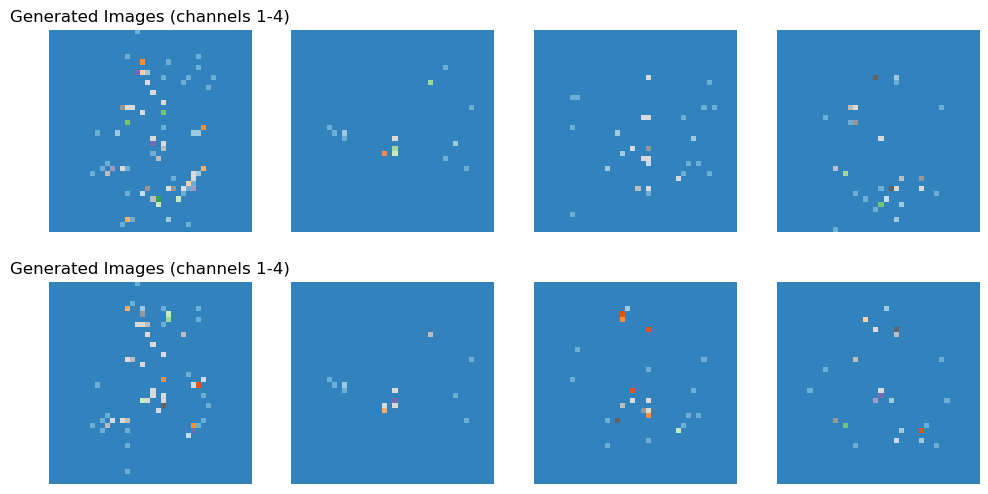

In [38]:
#load a model
#decoder = tf.keras.models.load_model("6731_30March_test_decoder")

z_gen = np.random.normal(size=(2,embsize))

recons_embed = generator.predict(z_gen)
print(recons_embed.shape)

from matplotlib import pyplot as plt
from scipy import ndimage

cmap="tab20c"

def new_images(image,channel):
    recons = image[:,:,channel] #last number cycles through channels 0-3
    rot = ndimage.rotate(recons, 0)
    rot  = rot[20:60, 20:60]
    return rot

newimages=[]
newimages2=[]
for i in range(4):
    new1 = new_images(image=recons_embed[0],channel=i)
    newimages.append(new1)
    new1 = new_images(image=recons_embed[1],channel=i)
    newimages2.append(new1)
    
#can insert scaling code here

fig, arrax = plt.subplots(2, 4, figsize=(12,6))
for i in range(4):
    arrax[0,i].imshow(newimages[i],cmap=cmap)
    arrax[1,i].imshow(newimages2[i],cmap=cmap)
    arrax[0,i].axis("off")
    arrax[1,i].axis("off")
arrax[0,0].set_title("Generated Images (channels 1-4)")
arrax[1,0].set_title("Generated Images (channels 1-4)")

plt.show()

## Save GAN components

In [39]:
discriminator.save("6731_1April_test_discriminator",save_format="tf")
print("Discriminator model saved.")

generator.save("6731_1April_test_generator",save_format="tf")
print("Generator model saved.")

INFO:tensorflow:Assets written to: 6731_1April_test_discriminator\assets


INFO:tensorflow:Assets written to: 6731_1April_test_discriminator\assets


Discriminator model saved.


INFO:tensorflow:Assets written to: 6731_1April_test_generator\assets


INFO:tensorflow:Assets written to: 6731_1April_test_generator\assets


Generator model saved.


## Load and restart training on the GAN

In [37]:
#autoencoder = tf.keras.models.load_model("6731_30March_test")
epcs = 50

dcgan.compile(d_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0001),
             g_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.5, beta_2 = 0.999))

dcgan.fit(dataset.X, epochs = epcs+20, initial_epoch = epcs)

Epoch 51/70
211/211 [==============================] - 99s 443ms/step - d_loss: 0.7496 - g_loss: 0.6111
Epoch 52/70
211/211 [==============================] - 102s 486ms/step - d_loss: 0.7420 - g_loss: 0.6152
Epoch 53/70
211/211 [==============================] - 105s 497ms/step - d_loss: 0.7731 - g_loss: 0.5896
Epoch 54/70
211/211 [==============================] - 105s 496ms/step - d_loss: 0.7361 - g_loss: 0.6198
Epoch 55/70
211/211 [==============================] - 107s 506ms/step - d_loss: 0.7069 - g_loss: 0.6440
Epoch 56/70
211/211 [==============================] - 110s 523ms/step - d_loss: 0.7528 - g_loss: 0.6073
Epoch 57/70
211/211 [==============================] - 109s 518ms/step - d_loss: 0.7331 - g_loss: 0.6220
Epoch 58/70
211/211 [==============================] - 108s 514ms/step - d_loss: 0.7425 - g_loss: 0.6158
Epoch 59/70
211/211 [==============================] - 109s 518ms/step - d_loss: 0.7489 - g_loss: 0.6038
Epoch 60/70
211/211 [==============================] - 1

## Code for scaling images

In [ ]:
#scaling for images
biggest, smallest = 0.0, 6000.0
tmp=np.empty(2)
for i in range(4):
    tmp[0] = newimages[i].max()
    tmp[1] = oldimages[i].max()
    tmps = tmp.max()
    if tmps > biggest:
        biggest = tmps
    tmp[0] = newimages[i].min()
    tmp[1] = oldimages[i].min()
    tmps = tmp.min()
    if tmps < smallest:
        smallest = tmps
scaled_newimages = ((newimages - smallest) * (1/(biggest-smallest)) * 255).astype('uint8')
scaled_oldimages = ((oldimages - smallest) * (1/(biggest-smallest)) * 255).astype('uint8')